In [2]:
import numpy as np

In [3]:
import matplotlib

In [4]:
import scipy

In [5]:
import shapely

In [6]:
import geopandas

In [7]:
import sklearn

In [8]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow

2024-10-07 16:18:25.577373: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 16:18:25.583368: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 16:18:25.657126: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 16:18:25.750165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 16:18:25.852710: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [10]:

import utm



This method convert landslide polygon data to landslide polygon Images.
These converted landslide images are used as a input to CNN for landslide classification

In [11]:
import image_based_method

In [14]:
#from image_based_method import make_ls_images
#from image_based_method import classify_inventory_cnn
#from image_based_method import plot_geometric_results
from image_based_method import read_shapefiles
import numpy as np

EARTHQUAKE SHAPEFILES

In [15]:
earth_hokkaido_shapefile = read_shapefiles("/home/snehal/Documents/landsifier/landsifier/Topological_feature_based_method/Japan Inventory/Earthquake_hokkaido_polygons.shp")
earth_iwata_shapefile = read_shapefiles("/home/snehal/Documents/landsifier/landsifier/Topological_feature_based_method/Japan Inventory/Earthquake_iwata_polygons.shp")
earth_niigata_shapefile =read_shapefiles("/home/snehal/Documents/landsifier/landsifier/Topological_feature_based_method/Japan Inventory/Earthquake_niigata_polygons.shp")
    

UTM (Universal Transverse Mercator) coordinates are a type of Cartesian coordinate system used for mapping and navigation purposes. Unlike latitude and longitude, which are geographic coordinates, UTM coordinates are in meters, which makes them useful for calculations related to distance and area.


What are UTM Coordinates?

UTM coordinates consist of:

    Easting: The x-coordinate in the UTM system. It represents the distance (in meters) eastward from a reference point, called the central meridian of the UTM zone.
    Northing: The y-coordinate in the UTM system. It represents the distance (in meters) northward from the equator (in the Northern Hemisphere) or from a reference line south of the equator (in the Southern Hemisphere).

The UTM system divides the Earth into 60 longitudinal zones, each of which is 6 degrees wide. Each zone is projected using a Transverse Mercator projection, which preserves distances, angles, and shapes well over smaller areas.
Why Use UTM Coordinates?

    Distance and Area Calculations: Since UTM coordinates are in meters, calculating distances and areas is much easier compared to using geographic coordinates (latitude and longitude), which are in degrees.
    Local Accuracy: The UTM projection maintains accuracy in a smaller, local region, unlike latitude/longitude, which has distortions over large areas.

In [16]:
def latlon_to_eastnorth (lonlat_polydata):
    
    """ 
    function to convert the (longitude latitude) coordinates of polygons to UTM(easting, northing) coordinates
    
    
    Parameters:
          :lonllat_polydata (array_like): 
                             longitude and latitude coordinates data
                      
    Returns:
            (array_like)
            easting and northing coordinates of landslide polygon data when polygon data has longitude latitude coordinates 

    i.e., converts geographic coordinates to Cartesian coordinates).
     
    """
     
    east_north_polydata=[]  # initializes an empty list to store the converted coordinates.
    
    #np.shape(lonlat_polydata)[0]: Gets the number of coordinate pairs in the data. 
    # For example, if lonlat_polydata is a list of 10 points, np.shape(lonlat_polydata)[0] will return 10

    for i in range(np.shape(lonlat_polydata)[0]):  # A for loop is used to iterate over each point in lonlat_polydata.
        u = utm.from_latlon(lonlat_polydata[i][1], lonlat_polydata[i][0])   ### (lat,lon) to (east,north)
        east_north_polydata.append([u[0],u[1]]) #Appends the resulting (easting, northing) coordinate to the east_north_polydata list.
    east_north_polydata=np.asarray(east_north_polydata) #Converts east_north_polydata to a NumPy array and returns it
    return  east_north_polydata  

Increase_resolution_polygon Function

Purpose: Increase the number of points in a polygon for smoother representation, effectively performing linear interpolation between the original points.

In [17]:
def increase_resolution_polygon(data):
    """
    function to increase the data points between two neighbouring vertex of landslide polygon to get smooth images
    
    Parameters:
            :data (array_like):
                               easting and northing coordinates data of landslide polygon
     
    Returns:
            (array_like)
            linear interpolated data of landslide polygon
    """
    N=100 #N is the number of points you want between two neighboring vertices. This increases the resolution by adding more points between each original pair.
    n=np.shape(data)[0]-1  #n is the number of edges between the vertices (since the shape of data gives the number of vertices).
    dat=[]   # dat initializes an empty list to store interpolated points.
    for j in range(n):
        x1,y1=data[j]  # coordintaes of starting points of an edge
        x2,y2=data[j+1] # coordinates of ending points of an edge
        x_dis,y_dis=np.abs(x1-x2),np.abs(y1-y2)      #    x_dis and y_dis are the absolute differences between the coordinates of the two points.
        x=min(x1,x2) # x is the minimum of x1 and x2. It is used to ensure we interpolate between the minimum and maximum coordinates.
        for i in range(1,N):    # This nested loop adds interpolated points between x1, y1 and x2, y2.
            xx=x+(x_dis/N)*i 
            if x2 != x1:
                 yy = y1 + ((y2 - y1) / (x2 - x1)) * (xx - x1)  # yy is calculated using linear interpolation.
            else:
             yy = y1  # Set yy to y1 when x1 == x2 (i.e., a vertical line)
   
            #yy=y1+((y2-y1)/(x2-x1))*(xx-x1)    # yy is calculated using linear interpolation.
            dat.append([xx,yy])    #then append the coordinates
            
    dat=np.asarray(dat)    # Converts dat to a NumPy array and returns it.
    return dat

if x1, y1 = (0, 0) and x2, y2 = (10, 10), then xx and yy will generate points like (1, 1), (2, 2), ... to increase the resolution.


make_ls_images Function

Purpose: Convert landslide polygon data into binary images (64x64), where the polygon is represented as white pixels (255) on a black background (0).

In [18]:
def make_ls_images(poly_data):
    
    """
    function to convert landslide polygon to images
    
    Parameters:
          :poly_data :readed landslide inventory shapefile 
                
    Returns:
        (array_like) Bnary pixels values of landslide polygon Image 
    """   
    
    DATA=[]  #Initializes an empty list DATA to store the images.  
    
    for l in range(np.shape(poly_data)[0]):   # Iterates over each row of poly_data.

        if poly_data['geometry'][l].geom_type=='Polygon':   # Checks if the geometry type is 'Polygon'.

            polygon_data=np.asarray(poly_data['geometry'][l].exterior.coords)  # Converts the exterior coordinates of the polygon to a NumPy array.
             
            if np.nanmin(polygon_data) < 100: # If the minimum value in polygon_data is less than 100, it is assumed to be in latitude/longitude 
                #(since latitudes/longitudes are typically below 100 degrees).
                # Converts polygon_data to easting/northing using the latlon_to_eastnorth function.
               polygon_data=latlon_to_eastnorth(polygon_data)   
            
            polygon_data=polygon_data[~np.isnan(polygon_data).any(axis=1)]      ### remove any Nan Values in polygon
            ####################################################################################################
            polygon_new_data=increase_resolution_polygon(polygon_data)   # Uses increase_resolution_polygon to add more points to polygon_data.
            x_new=polygon_new_data[:,0]-np.nanmin(polygon_new_data[:,0])  # Subtracts the minimum values from x coordinates to normalize them to start from zero
            y_new=polygon_new_data[:,1]-np.nanmin(polygon_new_data[:,1])  # Subtracts the minimum values from y coordinates to normalize them to start from zero

            ########### CHECK THE CODE ################################
            if (np.max(x_new)<180) & (np.max(y_new)<180):  #Checks if the maximum values of x_new and y_new are less than 180 (ensuring the polygon fits within the image size).

                div=3
                #x1,y1=np.int32(x_new/div),np.int32(y_new/div)
                x1,y1=np.around(x_new/div),np.around(y_new/div) #Divides x_new and y_new by 3 to scale down the size and then rounds and converts them to integers.
                x1,y1=np.int32(x1),np.int32(y1)  
                
                k1,k2=32-int(np.max(x1)/2),32-int(np.max(y1)/2)  #    k1 and k2 are calculated to center the polygon in a 64x64 grid.
                x1,y1=x1+k1,y1+k2   # Adds k1 and k2 to x1 and y1 to shift the polygon to the center.
                
                
            #    Creates a 64x64 black image (image).
            #  Sets the corresponding pixels of the polygon to 255 (white).
            #  Flips the image vertically to correct the orientation.
            #  Appends the image to DATA.
                image=np.zeros((64,64))
                for i,j in zip(x1,y1):  
                    image[j,i]=255
                image=np.flip(image,axis=0)    
                DATA.append(image)
    DATA=np.asarray(DATA) #Converts DATA to a NumPy array and returns it.
    print(np.shape(DATA))
    
    """
    output of the function is binaryscale (64 x 64) images
    
    """
    return DATA   

    Conversion of Coordinates (latlon_to_eastnorth):
        Converts polygon data from geographic coordinates (longitude, latitude) to UTM coordinates (easting, northing).
        This is necessary when the input polygons are in geographic coordinates, ensuring all polygons are in a consistent coordinate system for subsequent steps.
        Dependency: Used later in the make_ls_images function when coordinates are below a specific threshold (likely indicating geographic coordinates).

    Increasing Resolution (increase_resolution_polygon):
        Adds more points between vertices of the polygon to increase resolution and create smoother shapes for visual representation.
        This is achieved using linear interpolation between each pair of adjacent vertices.
        Dependency: The result is used to generate more detailed images of polygons.

    Generating Landslide Images (make_ls_images):
        Converts landslide polygons to binary images with pixel values (either 0 or 255).
        Main Steps:
            Iterate Over Polygons: Loops through all polygons in the dataset.
            Coordinate System Check: If the minimum value of the polygon data is below a threshold (likely indicating geographic coordinates), it converts them to UTM using latlon_to_eastnorth.
            Remove NaNs: Ensures no NaN values remain in the coordinates.
            Increase Resolution: Uses increase_resolution_polygon to add more points and smooth the polygon.
            Shift Coordinates: Translates coordinates to start from zero, for proper image generation.
            Scaling and Centering: Scales down coordinates and centers them in a 64x64 grid.
            Create Image: Creates a binary image by setting pixel values at the polygon's coordinates to 255 (white).
        Dependency: This function depends on the latlon_to_eastnorth and increase_resolution_polygon functions to process the input polygon data correctly, and each of these processes feeds into the next to create the final image output.



In [19]:
feature_Earth_hokkaido=make_ls_images(earth_hokkaido_shapefile)

(2431, 64, 64)


In [20]:

feature_Earth_iwata=make_ls_images(earth_iwata_shapefile)
feature_Earth_niigata = make_ls_images(earth_niigata_shapefile)


(3959, 64, 64)
(8502, 64, 64)


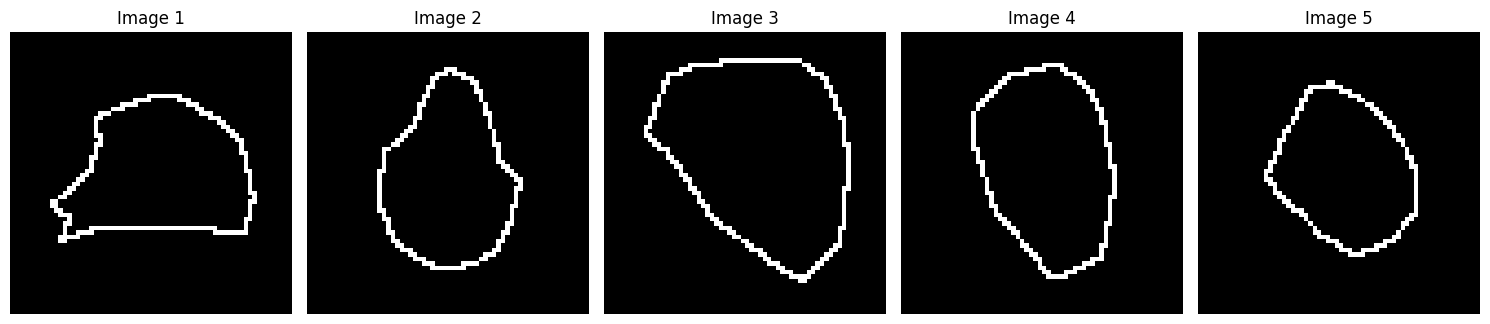

In [21]:
import matplotlib.pyplot as plt

# Assuming make_ls_images(poly_data) has already been called and returned DATA
DATA = feature_Earth_iwata

# Number of images to display
num_images_to_display = 5

# Create a plot to visualize the images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    # Ensure the index is within the range of DATA
    if i < len(DATA):
        axes[i].imshow(DATA[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()


RAINFALL SHAPEFILES

In [22]:
rain_kumamoto_shapefile = read_shapefiles("/home/snehal/Documents/landsifier/landsifier/Topological_feature_based_method/Japan Inventory/Rainfall_kumamoto_polygons.shp")
rain_fukuoka_shapefile = read_shapefiles("/home/snehal/Documents/landsifier/landsifier/Topological_feature_based_method/Japan Inventory/Rainfall_fukuoka_polygons.shp")
rain_saka_shapefile = read_shapefiles("/home/snehal/Documents/landsifier/landsifier/Topological_feature_based_method/Japan Inventory/Rainfall_saka_polygons.shp")


In [23]:
feature_Rain_kumamoto = make_ls_images(rain_kumamoto_shapefile)
feature_Rain_fukuoka = make_ls_images(rain_fukuoka_shapefile)
feature_Rain_saka = make_ls_images(rain_saka_shapefile)



(5281, 64, 64)
(1588, 64, 64)
(2550, 64, 64)


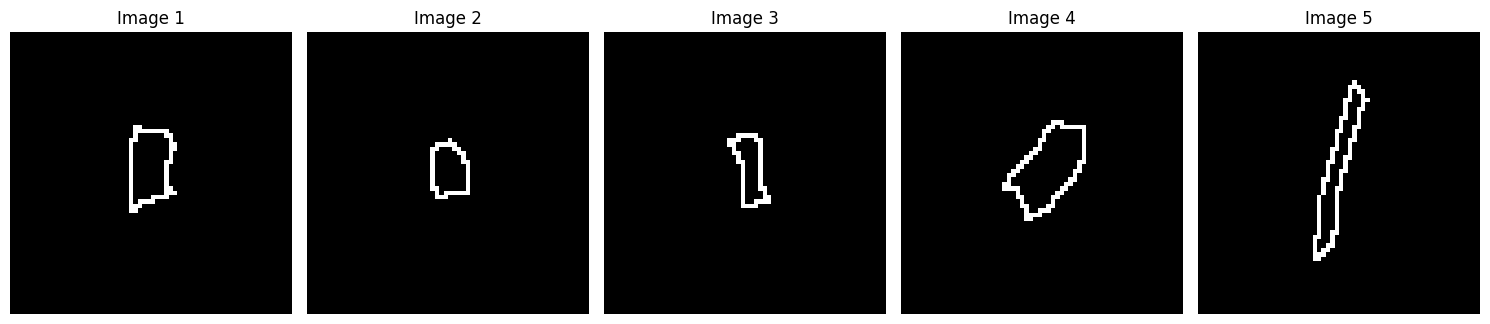

In [24]:
import matplotlib.pyplot as plt

# Assuming make_ls_images(poly_data) has already been called and returned DATA
DATA = feature_Rain_kumamoto

# Number of images to display
num_images_to_display = 5

# Create a plot to visualize the images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    # Ensure the index is within the range of DATA
    if i < len(DATA):
        axes[i].imshow(DATA[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()


In [25]:
earthquake_inventory_features=np.vstack((feature_Earth_iwata,feature_Earth_niigata))
rainfall_inventory_features=np.vstack((feature_Rain_fukuoka,feature_Rain_saka,feature_Rain_kumamoto))
test_inventory_features=feature_Earth_hokkaido


The train_augment function is designed to augment training data by applying various transformations (rotation, flipping) to the input images. This helps increase the size of the training dataset, providing more diverse examples, which in turn improves the model's ability to generalize.

In [26]:

def train_augment(train_data,train_label):
    """
    
    This function is used to augment the training data by rotating image by 90, 180, 270 degree and flippong image horizontally and
    vertically
    
    Parameters:
              :train_data (array_like): training data
              :train_label (array_like): training label
    
    Returns:
           augmented training data and labels
    
    
    """
    
    
    new_train=[]  #Initializes an empty list to store augmented training images.
    new_train_label=[]  # Initializes an empty list to store the corresponding labels for augmented images.
    for i in range(np.shape(train_data)[0]): #Loops over each training image.
        aa=train_data[i,:,:] # Extracts the i-th image from train_data. This is a 2D array representing pixel values of an image.
        bb=train_label[i]    # Extracts the corresponding label for the i-th image.
        new_train_label.append(bb) # Appends the label bb to new_train_label.
        new_train.append(aa)       # Appends the original image aa to new_train.
        
        
        aa_1=np.fliplr(aa)          # Flips the image aa horizontally (left to right).
        new_train.append(aa_1)      # Appends the horizontally flipped image to new_train
        new_train_label.append(bb)  # Appends the label bb to new_train_label. 
        # The label remains the same since the transformation doesn't change the class of the image.


        aa_2=np.flipud(aa)         #  Flips the image aa vertically (upside down).
        new_train.append(aa_2)     # Appends the vertically flipped image to new_train.
        new_train_label.append(bb)  #Appends the label bb to new_train_label
        
        bb_1=np.rot90(aa)           # Rotates the image aa by 90 degrees counterclockwise.
        new_train.append(bb_1)
        new_train_label.append(bb)  

        cc_1=np.rot90(bb_1)       # Rotates the previously rotated image (bb_1) by 90 degrees again, resulting in a total rotation of 180 degrees.
        new_train.append(cc_1)
        new_train_label.append(bb)

        dd_1=np.rot90(cc_1)        #Rotates the previously rotated image (cc_1) by 90 degrees again, resulting in a total rotation of 270 degrees.
        new_train.append(dd_1) 
        new_train_label.append(bb)     
        
    new_train=np.asarray(new_train)[:,:,:]  #Finally, converting the lists to NumPy arrays ensures the output is compatible with machine learning models, which typically require NumPy arrays as input.
    new_train_label=np.asarray(new_train_label)[:,:]  

    return new_train,new_train_label



The classify_inventory_cnn function is designed to classify landslide images into two categories: those triggered by earthquakes and those triggered by rainfall. It uses a Convolutional Neural Network (CNN) for this classification task.

In [27]:
import random

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix  
from sklearn.ensemble import RandomForestClassifier
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from mpl_toolkits.mplot3d import Axes3D
#import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
import random

In [29]:
def classify_inventory_cnn(earthquake_inventory_features,rainfall_inventory_features,test_inventory_features):
    
    """
    function to give probability of testing inventory belonging to earthquake and rainfall class
    
    Parameters:
        :earthquake_inventory_features (array_like): is landslide images of known earthquake inventories landslides
        :rainfall_inventory_features (array_like): is landslide images of known rainfall inventories landslides
        :test_inventory_features (array_like): is landslide images of known testing inventory landslides  
                
    Returns:
            (array_like) probability of testing inventory landslides belonging to earthquake and rainfall class

        
    """
    
     # Create labels for the two classes. Labels for earthquake samples are set to 0, and for rainfall samples, they are set to 1.
    earthquake_label=np.zeros((np.shape(earthquake_inventory_features)[0],1))
    rainfall_label=np.ones((np.shape(rainfall_inventory_features)[0],1))
   

    n1=np.shape(earthquake_inventory_features)[0]
    n2=np.shape(rainfall_inventory_features)[0]
    
    # Random Sampling for Balanced Training Set
    # If there are more earthquake samples than rainfall samples, it randomly samples from the earthquake dataset to match the number of rainfall samples.

    if n1>n2:  ### n1 is number of earth samples and n2 is number of rainfall samples #####
        indi_earth=random.sample(range(n1),n2)  #  randomly selects indices from the earthquake dataset.
        train_earth=earthquake_inventory_features[indi_earth,:]
        train_label_earth=earthquake_label[indi_earth]  

        train_rain=rainfall_inventory_features
        train_label_rain=rainfall_label
        #######################################################################################
        train_data=np.vstack((train_earth,train_rain))
        train_label=np.vstack((train_label_earth,train_label_rain))
        #print(np.shape(train_data)[0],np.shape(train_label)[0],np.shape(test_inventory_features)[0])

    else: # If there are more rainfall samples than earthquake samples, it randomly samples from the rainfall dataset to match the number of earthquake samples.
        indi_rain=random.sample(range(n2),n1)
        train_rain=rainfall_inventory_features[indi_rain,:]
        train_label_rain=rainfall_label[indi_rain]   
        train_earth=earthquake_inventory_features
        train_label_earth=earthquake_label        
        train_data=np.vstack((train_earth,train_rain))
        train_label=np.vstack((train_label_earth,train_label_rain))
        #print(np.shape(train_data)[0],np.shape(train_label)[0],np.shape(test_inventory_features)[0])

        #########################################################################################
    
    # The train_augment function is called to perform data augmentation on the training set,
    #  which helps improve the model's robustness by artificially increasing the size and diversity of the training data
    x_train,y_train=train_augment(train_data,train_label)

    # x_test is assigned the testing inventory features
    x_test=test_inventory_features
    #y_test=test_inventory_labels

    #img_rows and img_cols specify the input image dimensions.
    # dim specifies the number of channels (1 for grayscale).
    img_rows, img_cols,dim = 64, 64,1

  # hyperparameters
    batch_size=64
    epochs=30
    num_classes=2
    input_shape=(64,64,1)
    
    num_classes=2
    img_rows, img_cols,dim = 64, 64,1
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols,1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols,1)

    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    # converts labels into a one-hot encoded format suitable for categorical classification.
    
    #y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    
    x_train = x_train.astype('float32')  # this is a common format for image data in neural networks.
    x_test = x_test.astype('float32') 
    #x_train = np.expand_dims(x_train, axis=-1)
    #x_test = np.expand_dims(x_test, -1)
    
    
    model = Sequential()
    # Sequential() creates a linear stack of layers for the model.

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64,1)))
    # Conv2D adds convolutional layers with 32 filters of size 3×33×3 and the ReLU activation function.
    
    model.add(MaxPooling2D((2, 2)))
    #  reduces the spatial dimensions of the feature maps, helping to control overfitting and reduce computation.

    layers.Dropout(0.25),

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
   # converts the 2D feature maps to 1D, preparing the data for the dense layers.

    layers.Dropout(0.25),

    model.add(Dense(40, activation='relu'))
    #  adds a fully connected layer with 40 units.

    layers.Dropout(0.25),
    model.add(Dense(2, activation='softmax'))
    #  layer outputs probabilities for the two classes (earthquake and rainfall) using the softmax function.
    #model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


    hist=model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=0) 
    
    predictions=model.predict(x_test)
    
    """
       This functions print the probability of inventory belonging to earthquake and rainfall class
       
       Output of function is probability of each landslide in inventory class belonging to earthuake and rainfall class.
       The output of function is used for visualization of testing results
    
    """
    
    
    return predictions

plot_geometric_results(predict_proba): 
A function to visualize the probability predictions for landslide triggers, given predict_proba, an array of probabilities where each row has probabilities of belonging to earthquake or rainfall.

In [30]:
def plot_geometric_results(predict_proba):
    
    """
    function to visualize the trigger prediction of landslides in testing inventory
    
     
    Parameters:
         :predict_proba (array_like): probability of each landslide in inventory class belonging to earthquake and rainfall class.
                   
                   
    Returns:
         Visualization of landslide probabilities belong to earthquake and rainfall class and trigger prediction of entire landslide 
         inventory 
                
    """
    
    plt.rc('text', usetex=False)
    # chage xtick and ytick fontsize 
    # chage xtick and ytick fontsize 
    #plt.rc('text', usetex=True)
    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    #plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    plt.rcParams['font.family'] = 'sans-serif'

    plt.rcParams['pdf.fonttype'] = 42

    #n1 and n2: Count how many probabilities are greater than 0.5 for each of the two classes (earthquake and rainfall).
    n1=np.shape(np.argwhere(predict_proba[:,0]>0.5))[0]
    n2=np.shape(np.argwhere(predict_proba[:,1]>0.5))[0]
    
    def RF_image(predict_proba):
        predict_proba=np.int32(np.round(predict_proba*100))
        data=np.zeros((np.shape(predict_proba)[0],100))
        for i in range(np.shape(predict_proba)[0]):
            a,b=predict_proba[i,0],predict_proba[i,1]
            #################
            c=np.zeros(int(a),)
            d=np.ones(int(b),)
            if int(a)==100:
                mat=c
            elif int(b)==100:
                mat=d
            else:   
                mat=np.hstack((c,d))
            data[i,:]=mat
        data=np.transpose(data)
        return data 

    ##################################################################################
    #matrix_probability=RF_image(predict_proba)
    #image=np.dstack((matrix_probability,matrix_probability,matrix_probability))
    #image[matrix_probability[:,:]==0]=[230,204,179]
    #image[matrix_probability[:,:]==1]=[30,100,185]
    #image=np.int32(image)
    ###################################################################################
    import matplotlib as mpl
    fig,ax=plt.subplots(1, 1,figsize=(14,6), constrained_layout=True)
    cm = mpl.colors.ListedColormap([[230/255,204/255,179/255],[30/255,100/255,185/255]])
    
    if n1>n2: 
        earthquake_accuracy=np.round((n1/(n1+n2))*100,2) 
        ax.text(np.shape(predict_proba)[0]//4,110,' Probability of Earthquake: %s  '%earthquake_accuracy,fontsize=26)
        
        ind=np.argsort(predict_proba[:,0])
        predict_proba=predict_proba[ind,:]        
        matrix_probability=RF_image(predict_proba)
        image=np.dstack((matrix_probability,matrix_probability,matrix_probability))
        image[matrix_probability[:,:]==0]=[230,204,179]
        image[matrix_probability[:,:]==1]=[30,100,185]
        image=np.int32(image)
        
        
    else:
        rainfall_accuracy=np.round((n2/(n1+n2))*100,2) 
        ind=np.argsort(predict_proba[:,1])
        predict_proba=predict_proba[ind,:]        
        matrix_probability=RF_image(predict_proba)
        image=np.dstack((matrix_probability,matrix_probability,matrix_probability))
        image[matrix_probability[:,:]==0]=[230,204,179]
        image[matrix_probability[:,:]==1]=[30,100,185]
        image=np.int32(image)
        ax.text(np.shape(predict_proba)[0]//4,110,' Probability of Rainfall: %s '%rainfall_accuracy+'%',fontsize=26)
        #ax.text(np.shape(predict_proba)[0]//4,110,' Probability of Rainfall: %s '%rainfall_accuracy,fontsize=26)

        image=np.flipud(image)

    
    
    
    pcm = ax.imshow(image,aspect='auto',cmap=cm,origin='lower')
    ax.set_xlabel('Test Sample Index',fontsize=26)
    ax.set_ylabel('Class Probability',fontsize=26)
    

    #ax.text(1380,110,'85.31 $\pm$ 0.19 \%',fontsize=26)


    cb=plt.colorbar(pcm, location='top',pad=0.03,ax=ax)
    cb.ax.set_xticklabels([],size=0)                 # vertically oriented colorbar
    cb.ax.set_yticklabels([],size=0)                 # vertically oriented colorbar
    cb.ax.tick_params(axis=u'both', which=u'both',size=0)
    ax.text(np.shape(predict_proba)[0]//6,135,'Earthquake',fontsize=26)
    ax.text(np.shape(predict_proba)[0]//1.4,135,'Rainfall',fontsize=26)

    #cb.set_label('Earthquake                            Rainfall ',fontsize=26)
    plt.show()
    ##################################################################################    


In [50]:
predict_probability_hokkaido=classify_inventory_cnn(earthquake_inventory_features,rainfall_inventory_features,test_inventory_features)

/home/snehal/Documents/landsifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl


In [58]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

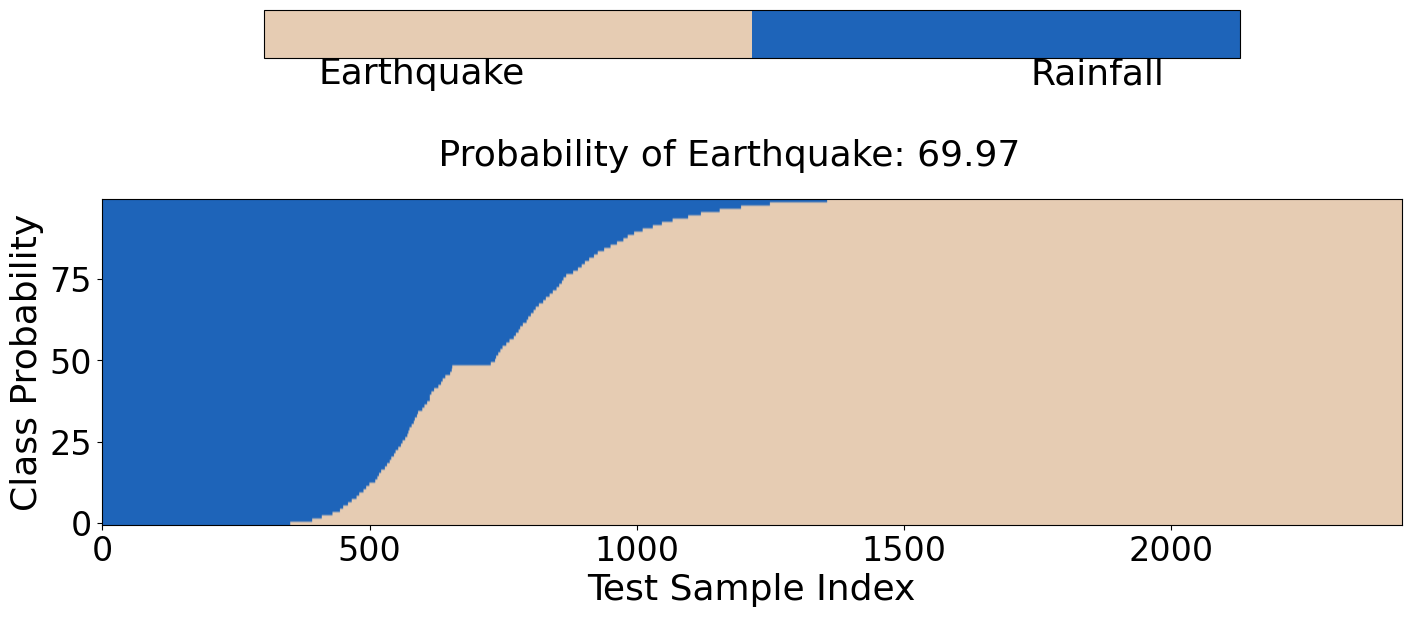

In [70]:
plot_geometric_results(predict_probability_hokkaido)

Case 2: Iwata (Earthquake -triggerd) is a testing inventory 

In [71]:
earthquake_inventory_features=np.vstack((feature_Earth_hokkaido,feature_Earth_niigata))
rainfall_inventory_features=np.vstack((feature_Rain_fukuoka,feature_Rain_saka,feature_Rain_kumamoto))
Test_inventory_features=feature_Earth_iwata
predict_probability_iwata=classify_inventory_cnn(earthquake_inventory_features,rainfall_inventory_features,test_inventory_features)


/home/snehal/Documents/landsifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

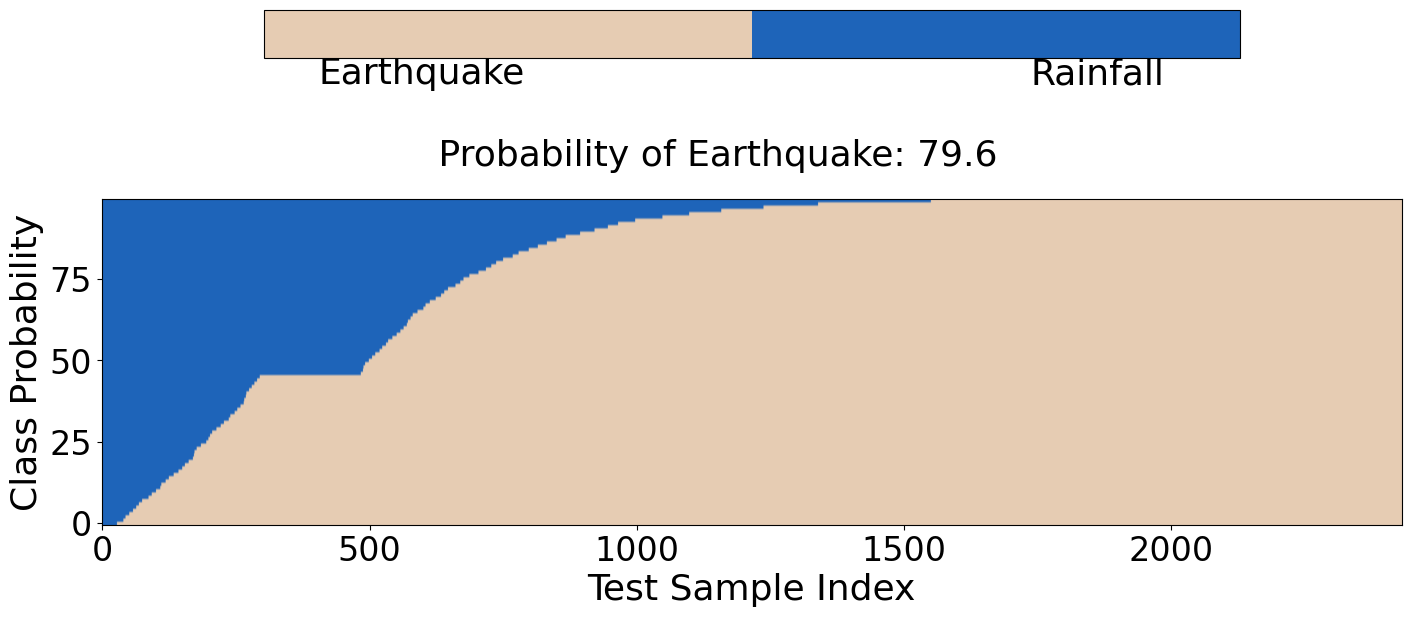

In [73]:
plot_geometric_results(predict_probability_iwata)


Case 3: Niigata (Earthquake -triggerd) is a testing inventory 

In [74]:
earthquake_inventory_features=np.vstack((feature_Earth_hokkaido,feature_Earth_iwata))
rainfall_inventory_features=np.vstack((feature_Rain_fukuoka,feature_Rain_saka,feature_Rain_kumamoto))
test_inventory_features=feature_Earth_niigata
predict_probability_niigata=classify_inventory_cnn(earthquake_inventory_features,rainfall_inventory_features,test_inventory_features)

/home/snehal/Documents/landsifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

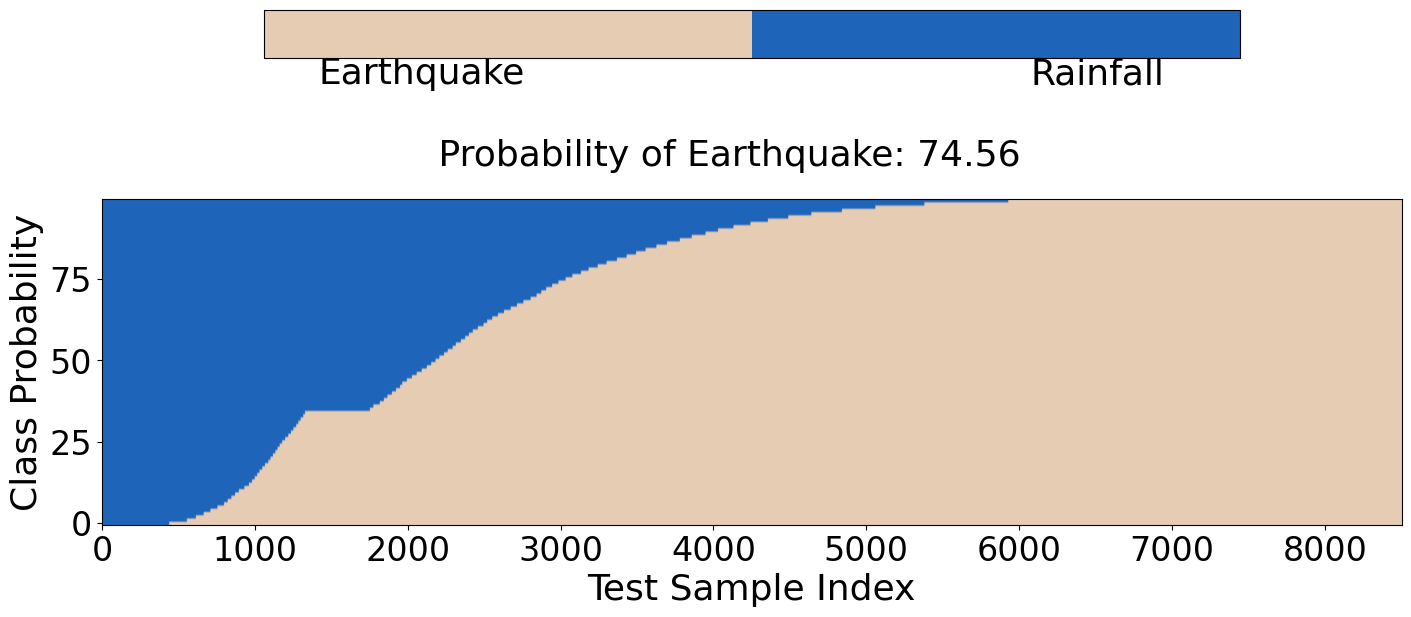

In [75]:
plot_geometric_results(predict_probability_niigata)


- Case 4: Kumamoto (Rainfall -triggerd) is a testing inventory 

In [76]:

earthquake_inventory_features=np.vstack((feature_Earth_hokkaido,feature_Earth_iwata,feature_Earth_niigata))
rainfall_inventory_features=np.vstack((feature_Rain_fukuoka,feature_Rain_saka))
test_inventory_features=feature_Rain_kumamoto
predict_probability_kumamoto=classify_inventory_cnn(earthquake_inventory_features,rainfall_inventory_features,test_inventory_features)

/home/snehal/Documents/landsifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

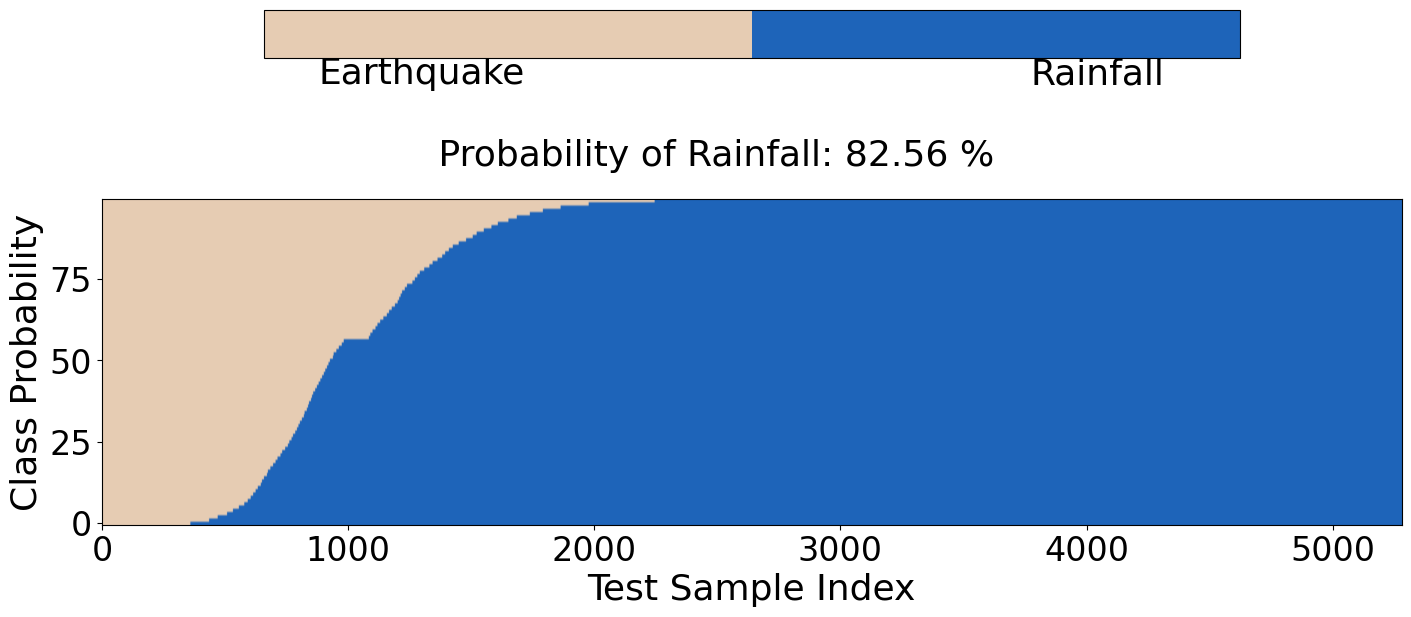

In [77]:
plot_geometric_results(predict_probability_kumamoto)
  


- Case 5: Fukuoka (Rainfall -triggerd) is a testing inventory 

In [78]:
earthquake_inventory_features=np.vstack((feature_Earth_hokkaido,feature_Earth_iwata,feature_Earth_niigata))
rainfall_inventory_features=np.vstack((feature_Rain_kumamoto,feature_Rain_saka))
test_inventory_features=feature_Rain_fukuoka
predict_probability_fukuoka=classify_inventory_cnn(earthquake_inventory_features,rainfall_inventory_features,test_inventory_features)

/home/snehal/Documents/landsifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

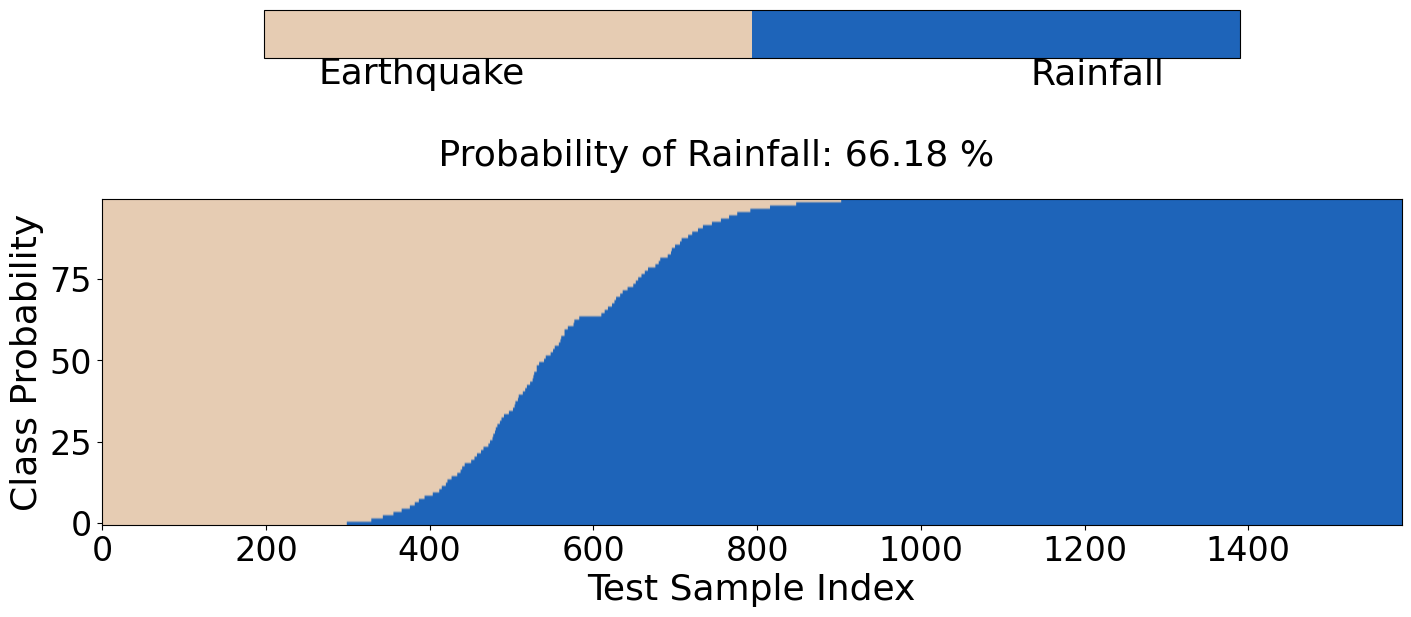

In [79]:
plot_geometric_results(predict_probability_fukuoka)


Case 6: Saka (Rainfall -triggerd) is a testing inventory 

In [80]:
earthquake_inventory_features=np.vstack((feature_Earth_hokkaido,feature_Earth_iwata,feature_Earth_niigata))
rainfall_inventory_features=np.vstack((feature_Rain_kumamoto,feature_Rain_fukuoka))
test_inventory_features=feature_Rain_saka

predict_probability_saka=classify_inventory_cnn(earthquake_inventory_features,rainfall_inventory_features,test_inventory_features)

/home/snehal/Documents/landsifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

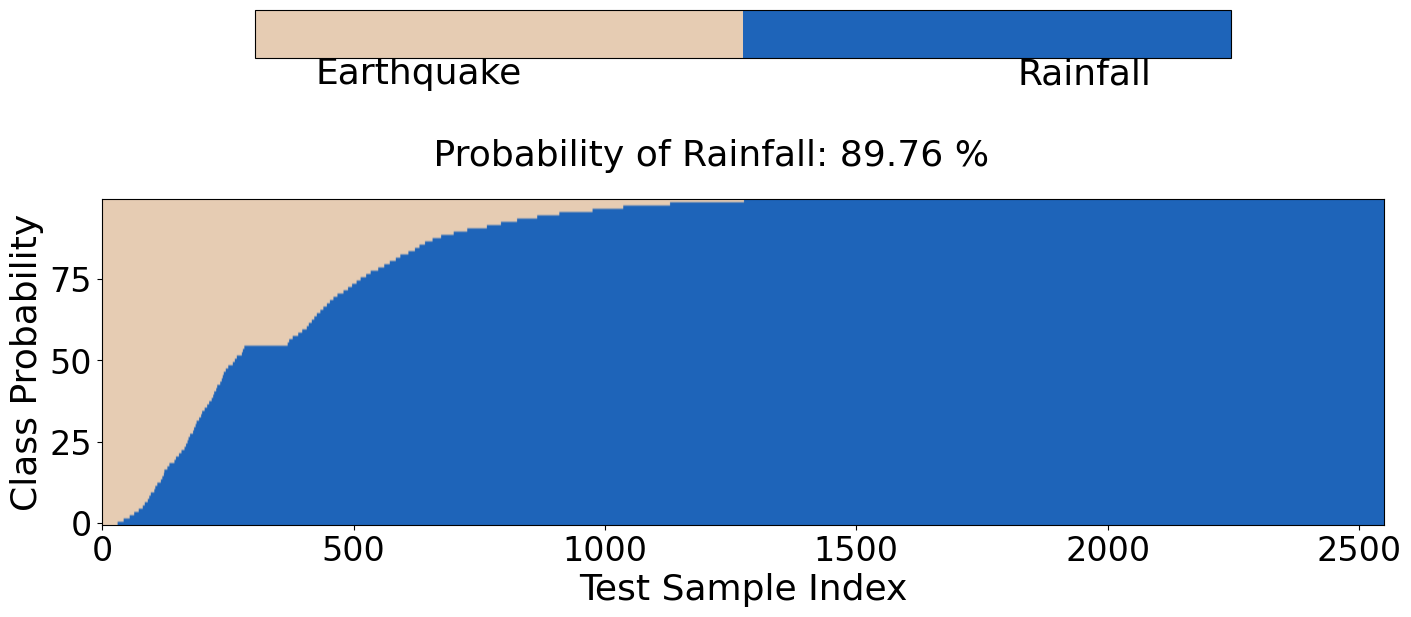

In [81]:
plot_geometric_results(predict_probability_saka)    

    

In [32]:
Data = read_shapefiles("/home/snehal/Documents/landsifier/landsifier/Topological_feature_based_method/eq_data/ground_failure_polygons.shp")

/home/snehal/Documents/landsifier/.venv/lib/python3.12/site-packages/pyogrio/raw.py:196: RuntimeWarning: /home/snehal/Documents/landsifier/landsifier/Topological_feature_based_method/eq_data/ground_failure_polygons.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [33]:
Landslide_data=Data[Data['type']!='Liquefaction']

REMOVE THE NULL VALUES

In [34]:
Landslide_data_not_null_gem = Landslide_data.dropna(subset=['geometry'])

In [35]:
Italy=Landslide_data_not_null_gem[Landslide_data_not_null_gem['epicentral']=='Italy']

In [36]:
myItaly= Italy.reset_index(drop=True)


In [37]:
feature_ITALY=make_ls_images(myItaly)

(243, 64, 64)


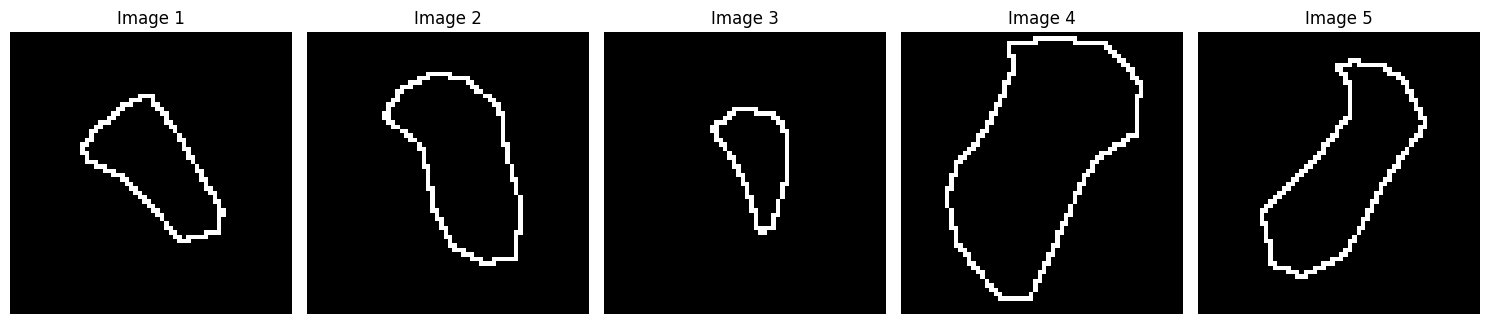

In [38]:
import matplotlib.pyplot as plt

# Assuming make_ls_images(poly_data) has already been called and returned DATA
DATA = feature_ITALY

# Number of images to display
num_images_to_display = 5

# Create a plot to visualize the images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    # Ensure the index is within the range of DATA
    if i < len(DATA):
        axes[i].imshow(DATA[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()


In [39]:
earthquake_inventory_features=np.vstack((feature_Earth_hokkaido,feature_Earth_iwata,feature_Earth_niigata))
rainfall_inventory_features=np.vstack((feature_Rain_fukuoka,feature_Rain_saka,feature_Rain_kumamoto))
test_inventory_features=feature_ITALY

In [40]:

predict_probability_italy=classify_inventory_cnn(earthquake_inventory_features,rainfall_inventory_features,test_inventory_features)

/home/snehal/Documents/landsifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


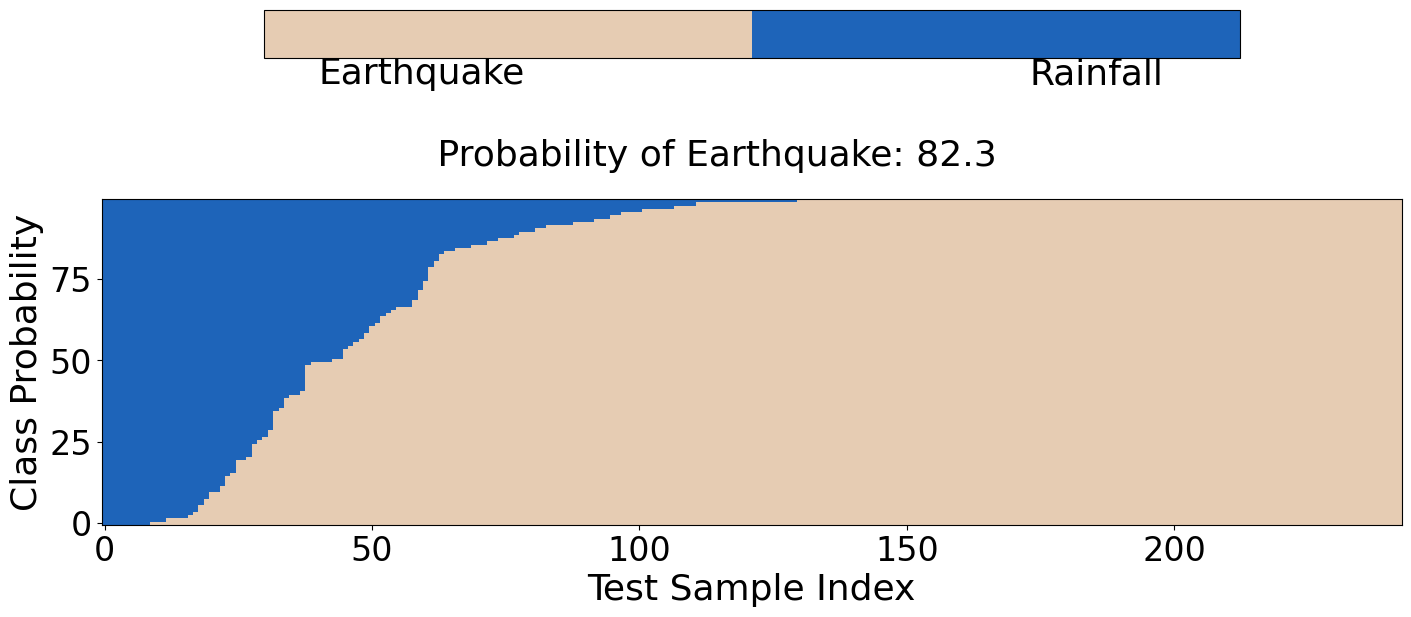

In [41]:
plot_geometric_results(predict_probability_italy)    